In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterstats import zonal_stats

import matplotlib.pyplot as plt

In [3]:
path_GeoTiff = r"E:\Projects\EverImpact\GitLab\ESRI_Hack2021\OCO2_data\GeoTiff\City_Clip"
path_shapefile = r"E:\Projects\EverImpact\GitLab\ESRI_Hack2021"

In [4]:
#Function to create a list of tif files, even when the tif files are stored in one location
#it is good to check for the correct file names when looping over the content of a folder
 
def clean_file_names(GeoTiff_name):
    filename = ""

    i = GeoTiff_name.find('_')
    if i == len("Barnsley"):                #check if the prefix is in the name      
        i = GeoTiff_name.find('.')
       
        if i == len("Barnsley")+3:          #check name and number e.g. Barnsley_10            
            if GeoTiff_name[-4:] != ".tif": #check for true tiff
                filename = GeoTiff_name
            #else:
            #    print(GeoTiff_name + " OK")
                
        else:
            filename = GeoTiff_name
    else:        
        filename = GeoTiff_name
    
    return filename

In [5]:
GeoTiff_filenames = next(os.walk(path_GeoTiff))[2]
# print(GeoTiff_filenames) #check for non geotiff files

for item in GeoTiff_filenames[::-1]: #reversed search because of removal of items
    not_tif = clean_file_names(item)
    
    if not_tif in GeoTiff_filenames:
        print(not_tif)
        GeoTiff_filenames.remove(not_tif)

print(GeoTiff_filenames)


Barnsley_merged2.tif
Barnsley_22.tif.aux.xml
Barnsley_03.tif.aux.xml
Barnsley_02.tif.aux.xml
Barnsley_01.tif.aux.xml
['Barnsley_01.tif', 'Barnsley_02.tif', 'Barnsley_03.tif', 'Barnsley_04.tif', 'Barnsley_05.tif', 'Barnsley_06.tif', 'Barnsley_07.tif', 'Barnsley_08.tif', 'Barnsley_09.tif', 'Barnsley_10.tif', 'Barnsley_11.tif', 'Barnsley_12.tif', 'Barnsley_13.tif', 'Barnsley_14.tif', 'Barnsley_15.tif', 'Barnsley_16.tif', 'Barnsley_17.tif', 'Barnsley_18.tif', 'Barnsley_19.tif', 'Barnsley_20.tif', 'Barnsley_21.tif', 'Barnsley_22.tif']


In [6]:
# Externally processed: "Barnsley_LCLU_intersect.shp"
# This is the intersection of Land Cover land Use with a regular 1km grid

zonal_shape = "Barnsley_LCLU_intersect.shp"
zonal_path = os.path.join(path_shapefile, zonal_shape)
zonal_path

'E:\\Projects\\EverImpact\\GitLab\\ESRI_Hack2021\\Barnsley_LCLU_intersect.shp'

In [7]:
gdf = gpd.read_file(zonal_path)
gdf.head()

,fid,LCLU_recla,geometry
0,56777.0,6,"MULTIPOLYGON (((3541918.102 3439812.758, 35419..."
1,56777.0,6,"MULTIPOLYGON (((3541499.356 3438967.647, 35415..."
2,56777.0,6,"MULTIPOLYGON (((3542137.795 3440166.918, 35421..."
3,56777.0,6,"POLYGON ((3542062.795 3439942.894, 3542062.029..."
4,56680.0,6,"POLYGON ((3540798.382 3443039.873, 3540806.161..."


In [8]:
GeoTiff_name = GeoTiff_filenames[0]
GeoTiff_path = os.path.join(path_GeoTiff, GeoTiff_name)
GeoTiff_path

'E:\\Projects\\EverImpact\\GitLab\\ESRI_Hack2021\\OCO2_data\\GeoTiff\\City_Clip\\Barnsley_01.tif'

In [9]:
raster_tif = rio.open(GeoTiff_path)

In [10]:
gdf['mean'] = pd.DataFrame(
    zonal_stats(
        vectors=gdf['geometry'], 
        raster=GeoTiff_path, 
        stats='mean'
    )
)['mean']

In [11]:
#Checking for small polygons without information

In [12]:
gdf.isna().sum()

fid             0
LCLU_recla      0
geometry        0
mean          502
dtype: int64

In [13]:
gdf["area"] =gdf['geometry'].area


In [14]:
#gdf.isna().sum()
total = gdf["area"].sum()
missing = gdf[gdf["mean"].isna()]["area"].sum().sum()
ratio = missing/total
print(f"Missing Area Ratio is {ratio:.4f} from {total:.0f} m2 ")

Missing Area Ratio is 0.0004 from 329237846 m2 


In [15]:
from pathlib import Path
#Output: Barnesley_LCLU_CO2.shp
#This shapefile will hold all the CO2 values by month on the LCLU polygons
zonal_ShapeFile = r"E:\Projects\EverImpact\GitLab\ESRI_Hack2021\00_Code\Barnesley_LCLU_CO2.shp"

run_process = True #long process to compute, removing the file will recreate 
                   #and go through the 22 grid files

my_file = Path(zonal_ShapeFile)
if my_file.is_file():
    # file exists
    # long process, so check if it neccessary to rerun
    print("file exists")
    run_process = False
    

run_process  

file exists


False

In [16]:
# Run process with check
i=0
if run_process:
    for item in GeoTiff_filenames:
        GeoTiff_path = os.path.join(path_GeoTiff, item)

        n = str(i).zfill(2)
        print(n)

        gdf['mean_'+ n] = pd.DataFrame(
            zonal_stats(
                vectors=gdf['geometry'], 
                raster=GeoTiff_path, 
                stats='mean'
            )
        )['mean']

        i+=1
        
    gdf.to_file(zonal_ShapeFile)
    
else:
    print("Process Skipped")
    gdf = gpd.read_file(zonal_ShapeFile)  
    

Process Skipped


In [17]:
gdf.describe()

,fid,mean,area,mean_00,mean_01,mean_02,mean_03,mean_04,mean_05,mean_06,...,mean_12,mean_13,mean_14,mean_15,mean_16,mean_17,mean_18,mean_19,mean_20,mean_21
count,9909.000000,9407.000000,9909.000000,9407.000000,9407.000000,9407.000000,9407.000000,9407.000000,9407.000000,9407.000000,...,9407.000000,9407.000000,9407.000000,9407.000000,9407.000000,9407.000000,9407.000000,9407.000000,9407.000000,9407.000000
mean,14052.109900,405.535570,33226.142487,405.535570,398.237079,400.090245,409.338444,402.604945,402.729592,411.581439,...,415.119894,417.677115,411.188454,419.092113,419.455310,411.085529,411.418640,413.188107,419.321149,420.680169
std,7322.172706,3.382904,79944.456353,3.382904,3.322021,3.305896,3.409303,3.386693,3.387741,3.442825,...,3.437285,3.458459,3.350033,3.414426,3.437983,3.417273,3.424105,3.439035,3.491142,3.502457
min,1.000000,401.262658,0.000000,401.262658,394.041091,394.852873,404.151109,397.671195,397.794304,406.764995,...,411.009674,413.541565,405.032281,412.817600,414.226183,406.912598,407.139709,408.958923,415.008263,416.353328
25%,8396.000000,402.036370,3801.854162,402.036370,394.800862,396.684092,405.838311,399.190545,399.314155,408.048455,...,411.572395,414.107748,407.844280,415.683669,415.949453,407.568846,407.898738,409.646492,415.731777,417.079175
50%,13682.000000,405.385091,10456.163597,405.385091,398.089274,399.953152,409.199161,402.441051,402.565652,411.439418,...,415.096313,417.653351,411.184313,419.087891,419.457733,411.048401,411.381055,413.149121,419.269576,420.628418
75%,19649.000000,408.556126,26903.971195,408.556126,401.203267,403.002151,412.351862,405.584570,405.710151,414.630459,...,418.052718,420.628037,413.982923,421.940284,422.358758,414.014313,414.351453,416.133433,422.310033,423.678781
max,65052.000000,414.079590,1000000.000000,414.079590,406.627319,408.350879,418.069275,411.469055,411.596436,420.409119,...,423.563965,426.173218,421.002228,429.094513,428.692810,419.558929,419.968475,421.770264,428.096924,429.484375


In [18]:
#gdf.head()

In [19]:
#checking the data (setting a subset) 

In [20]:
row = gdf.iloc[1001:2000]

a =row.iloc[:, 5:].T
a.reset_index(inplace=True)

a.drop(a[a["index"] == "geometry"].index, inplace=True)
a.drop(["index"], axis=1, inplace=True)


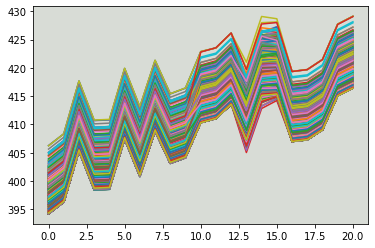

In [21]:
fig, ax = plt.subplots()
a[:].plot(ax=ax, legend=False)

#ax.set_ylabel('Land Cover Polygons (count)')
#ax.set_xlabel('CO2 concnetration (ppm)')
#ax.legend(["2015-05", "2021-05"]);
#ax.grid(axis='y')

ax.set_facecolor('#d8dcd6')

<AxesSubplot:ylabel='Frequency'>

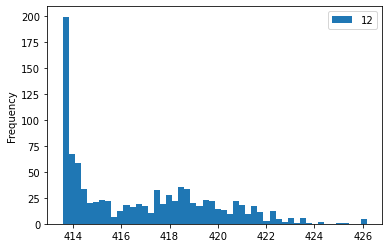

In [22]:
b=a[12:13].T #.plot()
b=b[2:]
b.plot.hist(bins=50)

In [23]:
b = gdf[["mean_00", "mean_10", "mean_16","mean_21"]]

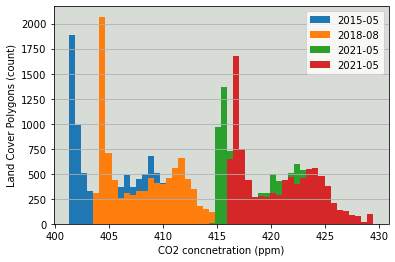

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False, title='Histogram: A vs. B')
b.plot.hist(ax=ax, bins=50)

ax.set_ylabel('Land Cover Polygons (count)')
ax.set_xlabel('CO2 concnetration (ppm)')
ax.legend(["2015-05", "2018-08", "2021-05", "2021-05"]);
ax.grid(axis='y')

ax.set_facecolor('#d8dcd6')

In [25]:
b.describe()

,mean_00,mean_10,mean_16,mean_21
count,9407.000000,9407.000000,9407.000000,9407.000000
mean,405.535570,408.158120,419.455310,420.680169
std,3.382904,3.398274,3.437983,3.502457
min,401.262658,403.607258,414.226183,416.353328
25%,402.036370,404.635345,415.949453,417.079175
50%,405.385091,408.013272,419.457733,420.628418
75%,408.556126,411.189163,422.358758,423.678781
max,414.079590,416.680237,428.692810,429.484375


In [26]:
# Load the observation table and interpolation table
fname = r"E:\Projects\EverImpact\GitLab\ESRI_Hack2021\00_Code\observation_months_date.csv"
calc_setup = pd.read_csv(fname)
calc_setup

,Date,ID,Year,Month,Label,OBS
0,15/05/2015,0,2015,5,2015-05,1
1,15/06/2015,1,2015,6,2015-06,0
2,15/07/2015,2,2015,7,2015-07,0
3,15/08/2015,3,2015,8,2015-08,0
4,15/09/2015,4,2015,9,2015-09,2
...,...,...,...,...,...,...
73,15/06/2021,73,2021,6,2021-06,0
74,15/07/2021,74,2021,7,2021-07,0
75,15/08/2021,75,2021,8,2021-08,0
76,15/09/2021,76,2021,9,2021-09,0


In [27]:
from scipy.interpolate import pchip
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
from scipy.interpolate import CubicHermiteSpline


In [28]:
# setup data
x = np.linspace(0, 10, 9)
y = np.sin(x)
xi = np.linspace(0, 10, 101)

In [29]:
# use fitpack2 method
ius = InterpolatedUnivariateSpline(x, y)
yi = ius(xi)

Text(0.5, 1.0, 'Interpolation using univariate spline')

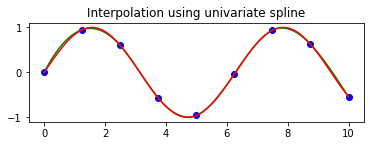

In [30]:
plt.subplot(2, 1, 1)
plt.plot(x, y, 'bo')
plt.plot(xi, yi, 'g')
plt.plot(xi, np.sin(xi), 'r')
plt.title('Interpolation using univariate spline')

In [31]:
#constructing the x labels for training
x = list(calc_setup[calc_setup['OBS'] > 0]["ID"])
x.append(77)
len(x)
#x

23

In [32]:
#gdf.head()

In [33]:
#constructing the y labels for training
y = gdf.iloc[[1], 4:-1].T.values.tolist()
y.append([412])
len(y)
#y

23

In [34]:
#constructing the xi container for the results
xi = calc_setup["ID"]
#xi

In [35]:
# use fitpack2 method
ius = InterpolatedUnivariateSpline(x, y)
yi = ius(xi)

Text(0.5, 1.0, 'Interpolation using univariate spline')

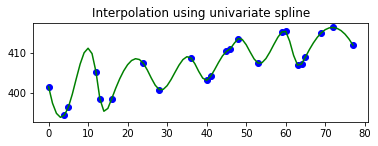

In [36]:
plt.subplot(2, 1, 1)
plt.plot(x, y, 'bo')
plt.plot(xi, yi, 'g')
#plt.plot(xi, np.sin(xi), 'r')
plt.title('Interpolation using univariate spline')

In [37]:
# use RBF method
rbf = Rbf(x, y)
fi = rbf(xi)

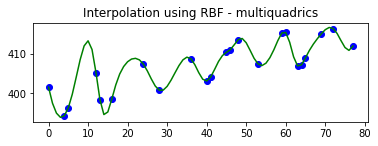

In [38]:
plt.subplot(2, 1, 2)
plt.plot(x, y, 'bo')
plt.plot(xi, fi, 'g')
#plt.plot(xi, np.sin(xi), 'r')
plt.title('Interpolation using RBF - multiquadrics')
plt.show()

In [39]:
#CubicHermiteSpline
p = CubicHermiteSpline(x=x, y=y, dydx=np.zeros_like(y))  # interpolator
fi = p(xi)


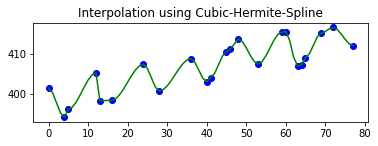

In [40]:
plt.subplot(2, 1, 2)
plt.plot(x, y, 'bo')
plt.plot(xi, fi, 'g')
#plt.plot(xi, np.sin(xi), 'r')
plt.title('Interpolation using Cubic-Hermite-Spline')
plt.show()

In [41]:
#Interpolation using Cubic-Hermite-Spline gives the best results


In [42]:
new_table = np.empty((0, len(fi)+1), dtype=float)
new_table

array([], shape=(0, 79), dtype=float64)

In [43]:
#Interpolating the CO2 value for all polygons using the 
#zonal statistic average and the selected method

#the loop will go over all polygons in the study area (10.000),
#and this could be optimised for larger datasets

for row in range(0, len(gdf)):
    #preparing y
    y = gdf.iloc[[row], 4:-1].T.values.tolist()
    b = True if True in np.isnan(np.array(y)) else False
    if b:
        #not complete
        fi = [0] * len(xi)
    else:
        y.append([412])

        p = CubicHermiteSpline(x=x, y=y, dydx=np.zeros_like(y))  # interpolator
        fi = p(xi)
        
    pid = gdf["fid"][row]
    new_row = fi.copy()
    
    new_row = np.insert(new_row, 0, pid)
    new_row = np.array(new_row)
    new_row = np.transpose(new_row)

    new_table = np.append(new_table, [new_row], axis=0)

print("done")

done


In [44]:
#

In [45]:
df = pd.DataFrame(data=new_table)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
count,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,...,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000
mean,14052.109900,384.990726,383.908111,381.526355,379.144600,378.061985,379.821267,380.307605,381.561844,383.276825,...,397.168174,398.077914,398.412402,399.033596,399.368084,398.511080,396.467456,394.028290,391.984666,391.127662
std,7322.172706,89.001330,88.751054,88.200445,87.649836,87.399559,87.805132,87.917607,88.207680,88.604320,...,91.816236,92.026555,92.103881,92.247487,92.324813,92.114500,91.618312,91.036052,90.556706,90.358026
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8396.000000,401.863932,400.733866,398.247721,395.761576,394.631510,396.482475,396.988415,398.295568,400.081886,...,414.592821,415.541016,415.890173,416.538608,416.887765,416.379437,415.167272,413.720493,412.508328,412.000000
50%,13682.000000,405.016190,403.877259,401.371611,398.865964,397.727033,399.591492,400.102735,401.414725,403.217370,...,417.849979,418.811608,419.163511,419.817043,420.168945,419.319375,417.293477,414.875469,412.849570,412.000000
75%,19649.000000,408.424303,407.275787,404.749050,402.222313,401.073796,402.872521,403.388090,404.720716,406.544296,...,421.215231,422.180269,422.535005,423.193801,423.548537,422.347489,419.483452,416.065085,413.201048,412.000000
max,65052.000000,414.079590,412.915173,410.353455,407.791737,406.627319,408.350879,408.887036,410.275708,412.174504,...,427.101469,428.096924,428.456633,429.124665,429.484375,427.666000,423.329875,418.154500,413.818375,412.000000


In [46]:
new_gdf = gdf.copy()

    
new_gdf.drop(new_gdf.iloc[:, 2:26], inplace = True, axis = 1)

for col in new_gdf.columns:
    print(col)

fid
LCLU_recla
geometry


In [47]:
new_gdf = new_gdf.join(df, lsuffix='fid', rsuffix='fid')

In [48]:
new_gdf.drop(new_gdf.columns[[3]], axis = 1, inplace = True)


In [49]:
col_idx = 0
for col in new_gdf.columns:
    #print(col)
    
    if isinstance(col, int):
        #print(type(col))
        AoI = "Barnsley"
        ID = str(col-1).rjust(2, '0')
        
        new_gdf.rename(columns={new_gdf.columns[col_idx]: AoI+ID}, inplace=True)
    
    col_idx += 1
    

In [50]:
#for col in new_gdf.columns:
#    print(col)

In [51]:
# Storing the interpolated data to a new shapefile
# this shapefile will be served as a FeatureLayer 
# on the ESRI Online platform and shared with both 
# the application and the story map

detailed_ShapeFile = r"E:\Projects\EverImpact\GitLab\ESRI_Hack2021\00_Code\Barnesley_LCLU_CO2_details.shp"
new_gdf.to_file(detailed_ShapeFile)

In [52]:
new_gdf.replace(0, np.nan, inplace=True)

In [53]:
df_mean = new_gdf.iloc[:, 3:82].mean(axis=0)

<AxesSubplot:>

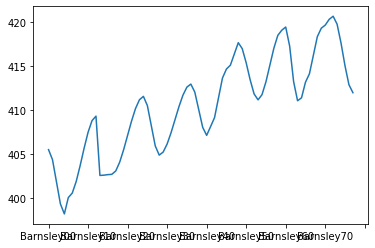

In [54]:
df_mean.plot()